In [20]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [21]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=ubWnuAa4wIHnDTz0Su8AYWJAM7fUMCps6AxyNzFok...,"Fri, 11 Nov 2022 02:57:49 GMT",GET,http://127.0.0.1:5000/orders/get/employee_id/5482,,404 NOT FOUND,application/json,39,404,"{""error"": ""Employee ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
127496,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=SkLWkaUE83sP38c3kf-XYBCKlSlSmBTQSEJw6EaMg...,"Fri, 11 Nov 2022 02:56:21 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=giYaDJkC2Oa-rCmlAvYglQzy_Em-YHTv_5aOjposX...,"Fri, 11 Nov 2022 02:49:37 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=VzOU9Ac91LxJ8UAvQ8Wt3c5Ua-30j4s9kcdTKrwCw...,"Fri,

In [22]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",None,None,None,None,Benign,Benign


In [23]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0,-0.755929,0,0,0,1,0,0,0,0,-0.646997,0,0.408248,4,-1.0,404,0.408248,-1.0,-1.0,-1.0,-1.0,Benign,Benign
1,0,0.000000,0,0,0,3,0,0,0,0,-0.480384,0,0.000000,0,-1.0,200,0.956183,-1.0,-1.0,-1.0,-1.0,Benign,Benign
2,0,-0.408248,0,0,0,1,0,1,0,0,0.426401,0,0.707107,0,-1.0,200,-0.255551,-1.0,-1.0,-1.0,-1.0,Benign,Benign
3,0,0.666667,0,0,0,2,0,0,0,0,-0.593391,0,0.577350,4,-1.0,404,0.408248,-1.0,-1.0,-1.0,-1.0,Benign,Benign
4,0,-0.471405,0,0,0,3,0,1,0,0,-0.652753,0,0.377964,4,-1.0,404,0.894427,-1.0,-1.0,-1.0,-1.0,Benign,Benign


In [24]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Host             127500 non-null  int32  
 1   request.headers.User-Agent       127500 non-null  float64
 2   request.headers.Accept-Encoding  127500 non-null  int32  
 3   request.headers.Accept           127500 non-null  int32  
 4   request.headers.Connection       127500 non-null  int32  
 5   request.headers.Accept-Language  127500 non-null  int32  
 6   request.headers.Sec-Fetch-Site   127500 non-null  int32  
 7   request.headers.Sec-Fetch-Mode   127500 non-null  int32  
 8   request.headers.Sec-Fetch-User   127500 non-null  int32  
 9   request.headers.Sec-Fetch-Dest   127500 non-null  int32  
 10  request.headers.Set-Cookie       127500 non-null  float64
 11  request.method                   127500 non-null  int32  
 12  re

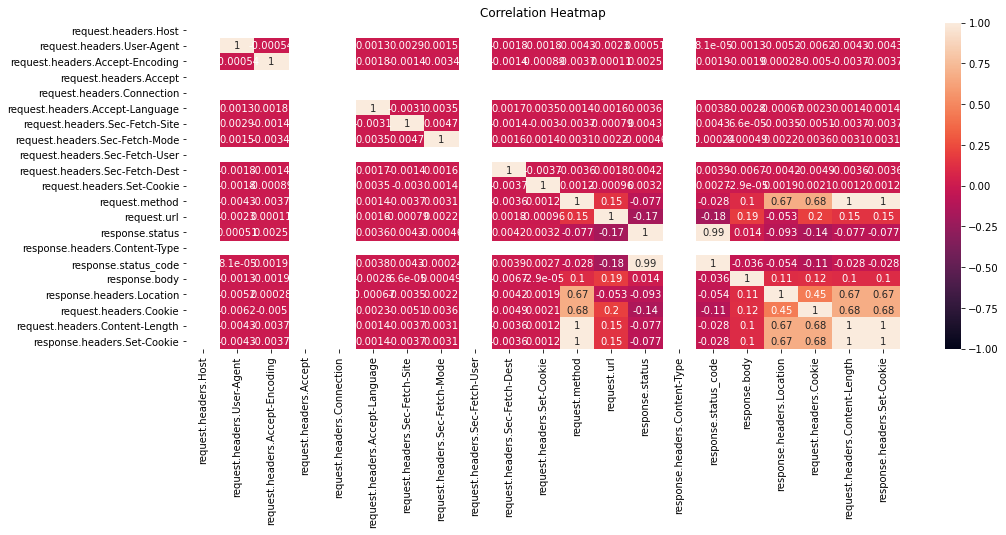

In [25]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [26]:
df.drop('response.headers.Set-Cookie', axis=1, inplace=True)
df.drop('request.method', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)
# df.drop('response.headers.Location', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.url,response.status,response.headers.Content-Type,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,attack_type,label
0,0,-0.755929,0,0,0,1,0,0,0,0,-0.646997,0.408248,4,-1.0,0.408248,-1.0,-1.0,-1.0,Benign,Benign
1,0,0.000000,0,0,0,3,0,0,0,0,-0.480384,0.000000,0,-1.0,0.956183,-1.0,-1.0,-1.0,Benign,Benign
2,0,-0.408248,0,0,0,1,0,1,0,0,0.426401,0.707107,0,-1.0,-0.255551,-1.0,-1.0,-1.0,Benign,Benign
3,0,0.666667,0,0,0,2,0,0,0,0,-0.593391,0.577350,4,-1.0,0.408248,-1.0,-1.0,-1.0,Benign,Benign
4,0,-0.471405,0,0,0,3,0,1,0,0,-0.652753,0.377964,4,-1.0,0.894427,-1.0,-1.0,-1.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,0,0.000000,0,0,0,2,0,1,0,0,-0.303046,0.377964,4,-1.0,0.447214,-1.0,-1.0,-1.0,Benign,Benign
127496,0,-0.471405,0,0,0,0,0,1,0,0,-0.125988,0.000000,0,-1.0,0.408248,-1.0,-1.0,-1.0,Benign,Benign
127497,0,0.000000,0,0,0,0,0,1,0,0,-0.363803,0.000000,0,-1.0,0.408248,-1.0,-1.0,-1.0,Benign,Benign
127498,0,-0.800000,0,0,0,1,0,1,0,0,-0.356348,0.377964,4,-1.0,0.000000,-1.0,-1.0,-1.0,Benign,Benign


# Check which fields don't matter

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Skewness: 0.000000
Kurtosis: 0.000000


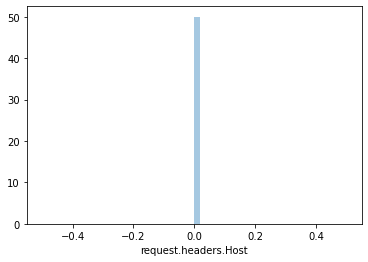

In [27]:
sns.distplot(df['request.headers.Host'])
print("Skewness: %f" % df['request.headers.Host'].skew())
print("Kurtosis: %f" % df['request.headers.Host'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Skewness: 29.561180
Kurtosis: 930.802791


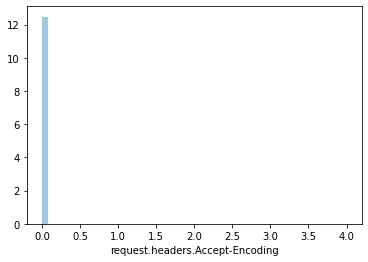

In [28]:
sns.distplot(df['request.headers.Accept-Encoding'])
print("Skewness: %f" % df['request.headers.Accept-Encoding'].skew())
print("Kurtosis: %f" % df['request.headers.Accept-Encoding'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Skewness: 0.000000
Kurtosis: 0.000000


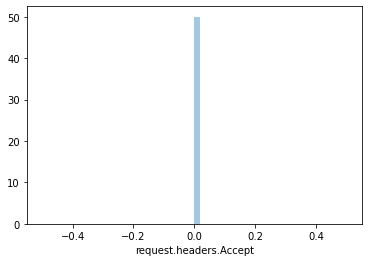

In [29]:
sns.distplot(df['request.headers.Accept'])
print("Skewness: %f" % df['request.headers.Accept'].skew())
print("Kurtosis: %f" % df['request.headers.Accept'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Skewness: 0.000000
Kurtosis: 0.000000


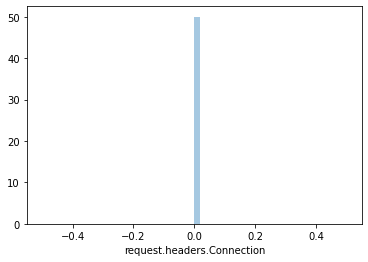

In [30]:
sns.distplot(df['request.headers.Connection'])
print("Skewness: %f" % df['request.headers.Connection'].skew())
print("Kurtosis: %f" % df['request.headers.Connection'].kurt())

Skewness: 29.250181
Kurtosis: 908.089458


C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


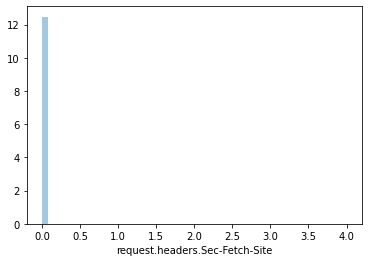

In [31]:
sns.distplot(df['request.headers.Sec-Fetch-Site'])
print("Skewness: %f" % df['request.headers.Sec-Fetch-Site'].skew())
print("Kurtosis: %f" % df['request.headers.Sec-Fetch-Site'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Skewness: 0.000000
Kurtosis: 0.000000


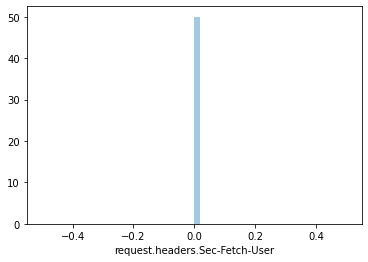

In [32]:
sns.distplot(df['request.headers.Sec-Fetch-User'])
print("Skewness: %f" % df['request.headers.Sec-Fetch-User'].skew())
print("Kurtosis: %f" % df['request.headers.Sec-Fetch-User'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Skewness: 30.174876
Kurtosis: 971.180991


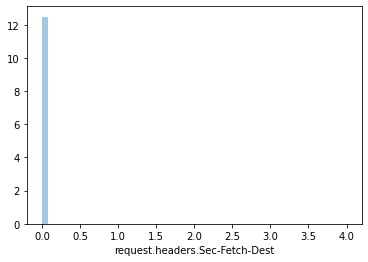

In [33]:
sns.distplot(df['request.headers.Sec-Fetch-Dest'])
print("Skewness: %f" % df['request.headers.Sec-Fetch-Dest'].skew())
print("Kurtosis: %f" % df['request.headers.Sec-Fetch-Dest'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Skewness: 0.000000
Kurtosis: 0.000000


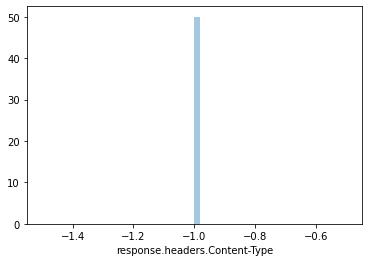

In [34]:
sns.distplot(df['response.headers.Content-Type'])
print("Skewness: %f" % df['response.headers.Content-Type'].skew())
print("Kurtosis: %f" % df['response.headers.Content-Type'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Skewness: 4.770848
Kurtosis: 24.060399


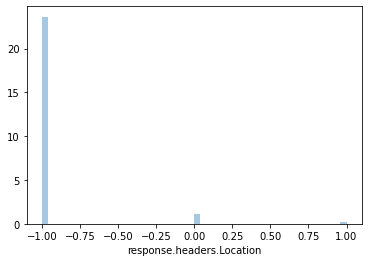

In [35]:
sns.distplot(df['response.headers.Location'])
print("Skewness: %f" % df['response.headers.Location'].skew())
print("Kurtosis: %f" % df['response.headers.Location'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Skewness: 7.724563
Kurtosis: 60.854903


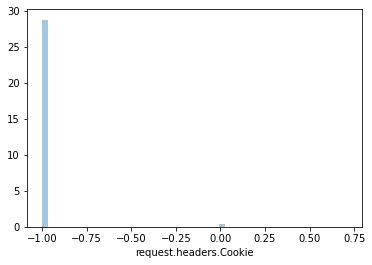

In [36]:
sns.distplot(df['request.headers.Cookie'])
print("Skewness: %f" % df['request.headers.Cookie'].skew())
print("Kurtosis: %f" % df['request.headers.Cookie'].kurt())

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Skewness: 10.127109
Kurtosis: 100.559913


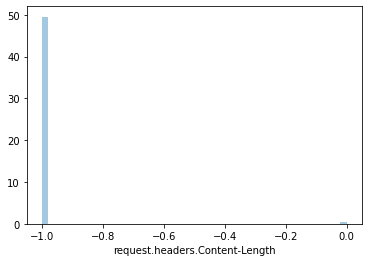

In [37]:
sns.distplot(df['request.headers.Content-Length'])
print("Skewness: %f" % df['request.headers.Content-Length'].skew())
print("Kurtosis: %f" % df['request.headers.Content-Length'].kurt())

## Drop unnecessary fields

In [38]:
df.drop('request.headers.Host', axis=1, inplace=True)
df.drop('request.headers.Accept', axis=1, inplace=True)
df.drop('request.headers.Connection', axis=1, inplace=True)
df.drop('request.headers.Sec-Fetch-User', axis=1, inplace=True)
df.drop('response.headers.Content-Type', axis=1, inplace=True)

In [39]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.url', 'response.status', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length']


request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.url                        float64
response.status                      int32
response.body                      float64
response.headers.Location          float64
request.headers.Cookie             float64
request.headers.Content-Length     float64
attack_type                         object
label                               object
dtype: object

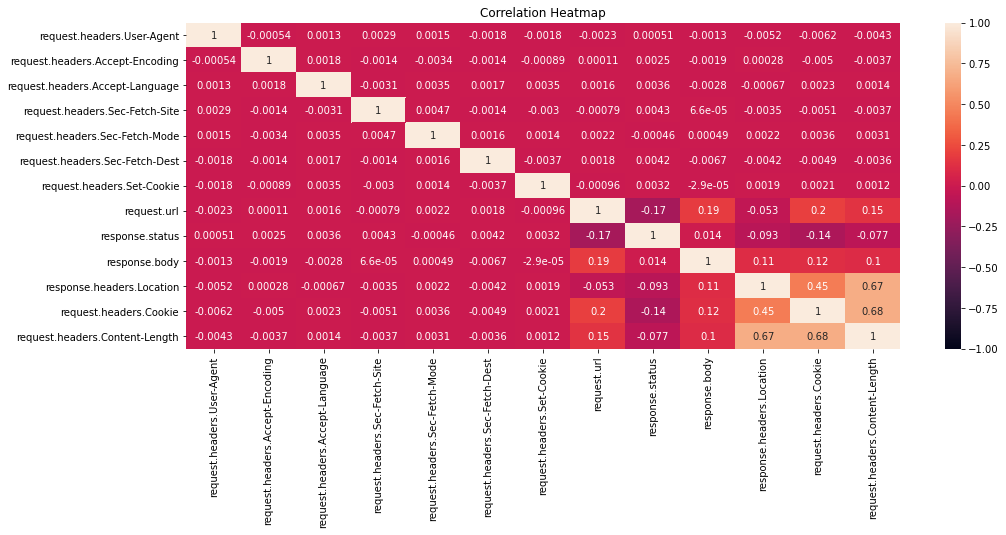

In [40]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

## Train test split

In [41]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 13) (104996,)
(22504, 13) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

## Model choosing and fitting

### Random Forest

In [42]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=95)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


## Result printout 

              precision    recall  f1-score   support

      Benign    0.98492   0.99174   0.98832     20812
     Malware    0.88889   0.81324   0.84938      1692

    accuracy                        0.97831     22504
   macro avg    0.93690   0.90249   0.91885     22504
weighted avg    0.97770   0.97831   0.97787     22504



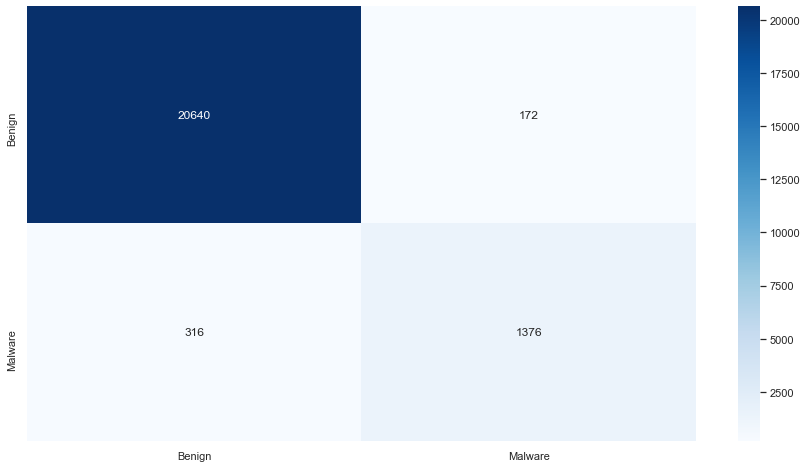

In [43]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

### Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB
nBase = GaussianNB()
nBase.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.94807   1.00000   0.97334     20812
     Malware    1.00000   0.32624   0.49198      1692

    accuracy                        0.94934     22504
   macro avg    0.97403   0.66312   0.73266     22504
weighted avg    0.95197   0.94934   0.93715     22504



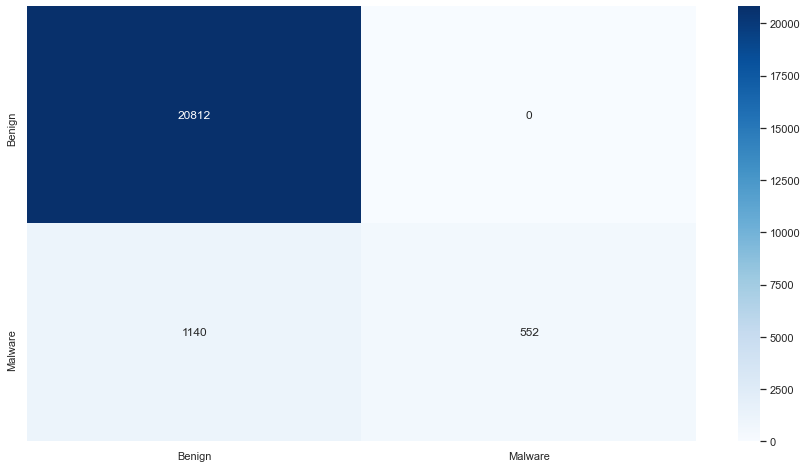

In [45]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = nBase.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

# SVM- try

In [46]:
# from sklearn import svm

# svmlin = svm.SVC(kernel='linear', C=0.9)
# # y_train[:] = [x if x != 'Benign' else 0 for x in y_train]
# # y_train[:] = [x if x != 'Malware' else 1 for x in y_train]
# svmlin.fit(X_train, y_train)
# # # Check data balance and variety
# print(sorted(Counter(y_train).items()))

In [47]:
# # We print our results
# sns.set(rc={'figure.figsize':(15,8)})
# prediction = svmlin.predict(X_test)
# # prediction[:] = [x if x != 'Benign' else 0 for x in prediction]
# # prediction[:] = [x if x != 'Malware' else 1 for x in prediction]
# true_labels = y_test
# # y_test[:] = [x if x != 'Benign' else 0 for x in y_test]
# # y_test[:] = [x if x != 'Malware' else 1 for x in y_test]
# lc_matrix = confusion_matrix(true_labels, prediction)
# lc_report = classification_report(true_labels, prediction, digits=5)
# heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
#                       xticklabels=np.unique(true_labels), 
#                       yticklabels=np.unique(true_labels)) 

# # The heatmap is cool but this is the most important result
# print(lc_report)

### Dummy

In [48]:
from sklearn.dummy import DummyClassifier

dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.92451   0.92274   0.92362     20812
     Malware    0.07159   0.07329   0.07243      1692

    accuracy                        0.85887     22504
   macro avg    0.49805   0.49801   0.49803     22504
weighted avg    0.86039   0.85887   0.85963     22504



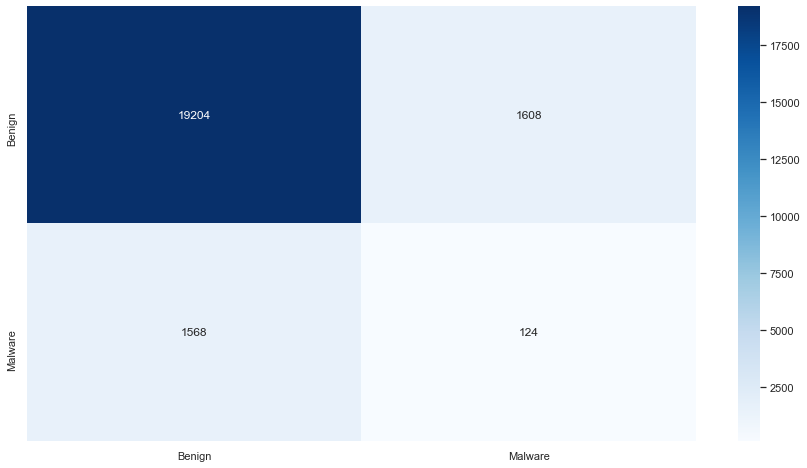

In [49]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = dum.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.97015   0.99476   0.98230     20812
     Malware    0.90636   0.62352   0.73880      1692

    accuracy                        0.96685     22504
   macro avg    0.93825   0.80914   0.86055     22504
weighted avg    0.96535   0.96685   0.96399     22504



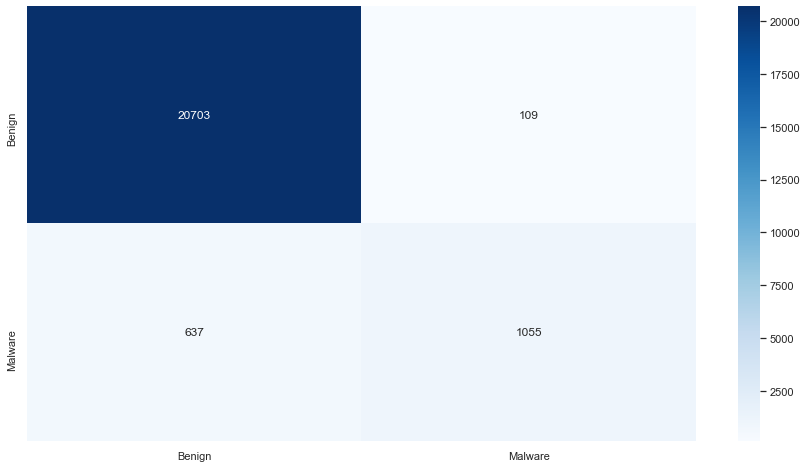

In [51]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Ridge

In [52]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.94553   1.00000   0.97200     20812
     Malware    1.00000   0.29137   0.45126      1692

    accuracy                        0.94672     22504
   macro avg    0.97276   0.64569   0.71163     22504
weighted avg    0.94962   0.94672   0.93285     22504



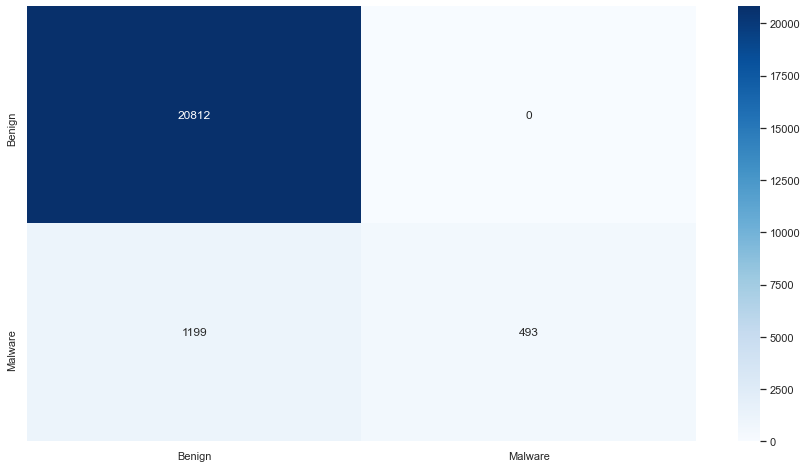

In [53]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### SVM SVC

In [54]:
# # from sklearn import svm
# svc = svm.SVC(gamma = 'auto')
# svc.fit(X_train, y_train)
# # Check data balance and variety
# print(sorted(Counter(y_train).items()))

In [55]:
# # We print our results
# sns.set(rc={'figure.figsize':(15,8)})
# prediction = svc.predict(X_test)
# true_labels = y_test
# lc_matrix = confusion_matrix(true_labels, prediction)
# lc_report = classification_report(true_labels, prediction, digits=5)
# heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
#                       xticklabels=np.unique(true_labels), 
#                       yticklabels=np.unique(true_labels)) 

# # The heatmap is cool but this is the most important result
# print(lc_report)

### Ada boost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=1000)
ada.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.97833   0.99995   0.98902     20812
     Malware    0.99919   0.72754   0.84200      1692

    accuracy                        0.97947     22504
   macro avg    0.98876   0.86375   0.91551     22504
weighted avg    0.97990   0.97947   0.97797     22504



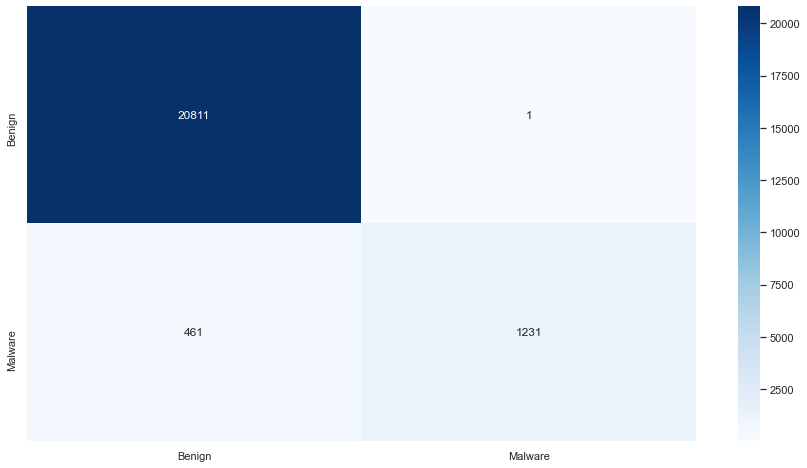

In [57]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Stacking

In [58]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)],
                            n_jobs = -1) 
stack.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.98386   0.99279   0.98831     20812
     Malware    0.90020   0.79965   0.84695      1692

    accuracy                        0.97827     22504
   macro avg    0.94203   0.89622   0.91763     22504
weighted avg    0.97757   0.97827   0.97768     22504



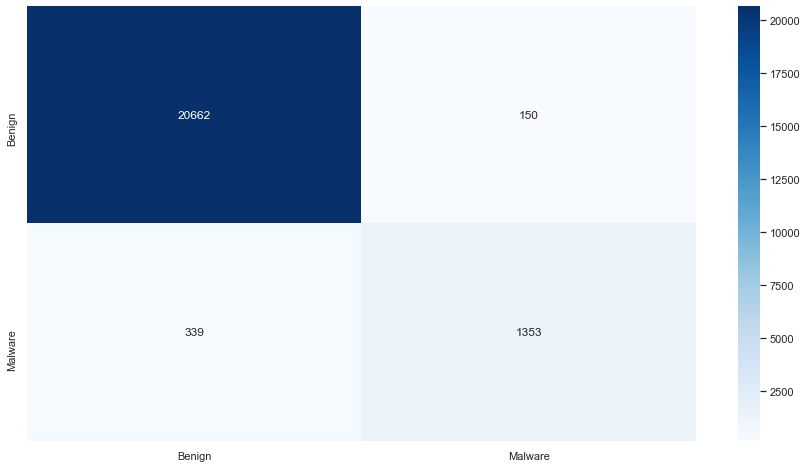

In [59]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### hard voting

In [64]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='hard')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.97833   1.00000   0.98905     20812
     Malware    1.00000   0.72754   0.84229      1692

    accuracy                        0.97951     22504
   macro avg    0.98916   0.86377   0.91567     22504
weighted avg    0.97996   0.97951   0.97801     22504



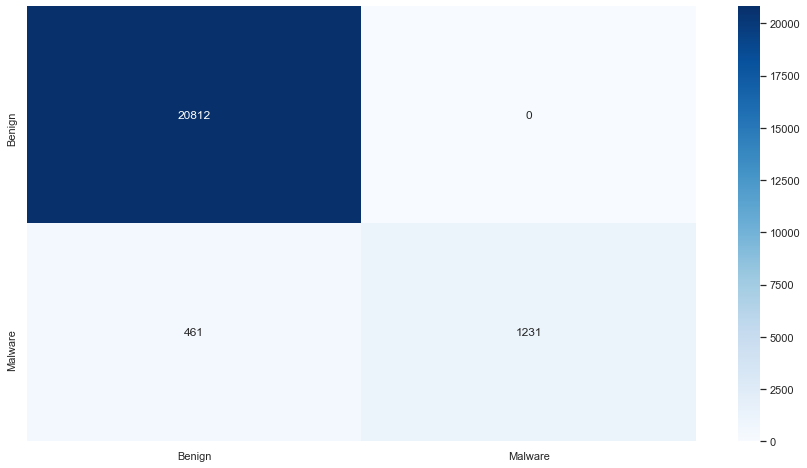

In [65]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### soft voting

In [66]:
vot_soft = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='soft')
vot_soft.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


              precision    recall  f1-score   support

      Benign    0.98487   0.99178   0.98832     20812
     Malware    0.88939   0.81265   0.84929      1692

    accuracy                        0.97831     22504
   macro avg    0.93713   0.90222   0.91880     22504
weighted avg    0.97770   0.97831   0.97786     22504



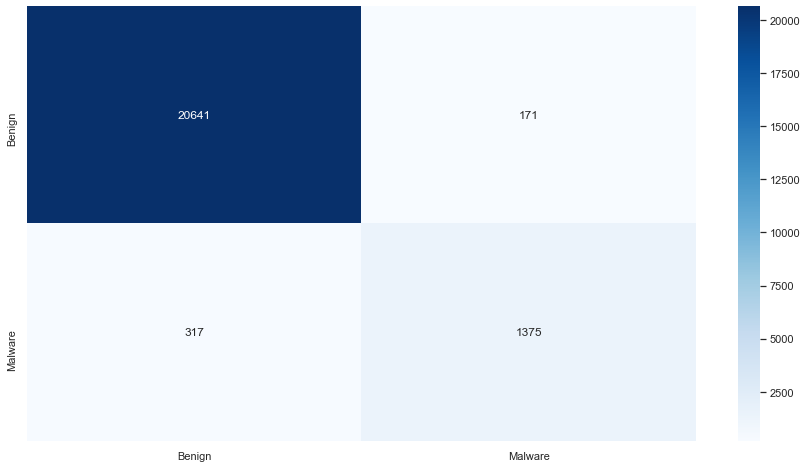

In [67]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot_soft.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)